<h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Partie <b>6</b><br>
<center>Fine Tuning d'un modèle Seq2Seq pré-entrainé<br>
sur <b>"small_vocab_en"</b> et <b>"small_vocab_fr"</b><br></center> 
<div style="text-align: right;">Version 2</div><br>
<hr style="border-width:2px;border-color:#1664c8">
</h1></bold>

#### Pour réaliser ce "Fine Tuning", nous avons extrait un certains nombre de phrases de  small_vocab  
#### Nous avons modifié les phrases fraçais et remplacé certains mot par d'autres:
- "camion"a été remplacé par "véhicule de sport"
- "rouillé" par "splendide"
- "vieux" par "flambant neuf"

#### Nous avons:
- ajouté les quelques nouveaux mots français au vocabulaire (véhicule, sport, splendide, flambant, neuf
- utilisé le modèle pré-entrainé
- entainé le modèle sur le nouveau corpus
- vérifié les nouvelles traductions sur le test set

### **1. Préparation des données**
> notamment la vectorisation

In [1]:
import os
import random
import warnings
warnings.filterwarnings('ignore')

def load_data(path):

    # Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
   
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

In [2]:
# Chargement des textes dans les 2 langues (max lignes = max_lines)
src = 'en'
tgt = 'fr'
txt_tgt = load_data('../data/small_vocab_fine_tuned_'+tgt)
txt_src = load_data('../data/small_vocab_fine_tuned_'+src)

print("Nombre de lignes:",len(txt_src),"\n")
for i in range(20):
    j = random.randint(0, len(txt_src))
    print(txt_src[j])
    print(txt_tgt[j],"\n")

text_pairs = []
text_tgt_to_vec = []
for line in range(len(txt_src)):
    text_pairs.append((txt_src[line], "[start] " + txt_tgt[line] + " [end]" ))
    text_tgt_to_vec.append(txt_tgt[line])


Nombre de lignes: 1945 

he is driving that big white truck .
il conduit ce gros véhicule de sport blanc . 

she likes that shiny blue truck .
elle aime ce véhicule de sport bleu brillant . 

he was driving the new black truck .
il conduisait le nouveau véhicule de sport noir . 

he disliked the old yellow truck .
il n'aimait pas le flambant neuf véhicule de sport jaune . 

she likes a little red truck .
elle aime un petit véhicule de sport rouge . 

she was driving that rusty red truck .
elle conduisait ce véhicule de sport rouge splendide . 

she dislikes that little yellow truck .
elle déteste ce petit véhicule de sport jaune . 

he is driving that old blue truck .
il conduit ce flambant neuf véhicule de sport bleu . 

he liked that big green truck .
il aimait ce gros véhicule de sport vert . 

he dislikes that rusty white truck .
il n'aime ce véhicule de sport blanc splendide . 

he drives that old black truck .
il conduit ce flambant neuf véhicule de sport noir . 

she saw the rus

**Initialisation de corpus 'train' (70% des phrases), 'validation' (15%) et 'test' (15%)**
> et melange de ces ensembles

In [3]:

# Mélange des paires de phrases
import random
random.Random(4).shuffle(text_pairs)
random.Random(4).shuffle(text_tgt_to_vec)
print(text_pairs[0])

# Definition de la taille des corpus
num_val_samples = int(0.15 * len(text_pairs)) # 15%
num_train_samples = len(text_pairs) - 2 * num_val_samples  # 70%

train_pairs = text_pairs[:num_train_samples]
train_tgt_to_vec = text_tgt_to_vec[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

('he disliked a new yellow truck .', "[start] il n'aimait pas un nouveau véhicule de sport jaune . [end]")


**Vectorisation des paires de texte anglaises et française avec le vocabulaire préalablement sauvé**  

In [4]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    lowercase=tf.strings.regex_replace(lowercase, "[à]", "a")
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

def load_vocab(file_path):
    with open(file_path, "r",  encoding="utf-8") as file:
        return file.read().split('\n')[:-1]

vocab_size = 15000
sequence_length = 30

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
    vocabulary = load_vocab("../data/vocab_"+src+".txt"),
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
    vocabulary = load_vocab("../data/vocab_fine_tuned_"+tgt+".txt"),
)

train_src_texts = [pair[0] for pair in train_pairs]
train_tgt_texts = [pair[1] for pair in train_pairs]


**Preparation des datasets 'train' et 'val' pour la tache de traduction**
> Nou transformons nos données en un pipeline tf.data.  
> Nous voulons qu'il renvoie un **tuple (inputs, target)** où inputs est un dict avec deux clés, **"encoder_inputs"** (la phrase source) et **"decoder_inputs"** (la phrase target), et **target** est la phrase target décalée d'un pas en avant.  
> La taille des batchs = 64

In [5]:
batch_size = 64

def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return ({
        src: source,
        tgt: target[:, :-1],
    }, target[:, 1:])

def make_dataset(pairs):
    src_texts, tgt_texts = zip(*pairs)
    tgt_texts = list(tgt_texts)
    src_texts = list(src_texts)
    dataset = tf.data.Dataset.from_tensor_slices((src_texts, tgt_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

**Definition d'ensemble de phrases test à traduite**

In [6]:
input_sentence=[]
true_translation=[]
for i in range(20):
    j = random.randint(0, len(test_pairs))
    input_sentence.append(test_pairs[j][0])
    true_translation.append((test_pairs[j][1])[8:-6])

### **2. Utilisation du traducteur Seq2Seq Transformer**

**Redéfinition de la couche 'customisée' TransformerDecoder** 
> Cette couche n'a pas pu être sauvé car elle est customisée

In [7]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

**Redéfinition de la couche 'customisée' PositionalEmbedding** 
> Cette couche n'a pas pu être sauvé car elle est customisée

In [8]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**Chargement du model entrainé**

In [9]:
from keras_nlp.layers import TransformerEncoder
transformer = keras.models.load_model(
    "../data/transformer-model-"+src+"-"+tgt+".h5",
    custom_objects={"PositionalEmbedding": PositionalEmbedding, "TransformerDecoder": TransformerDecoder},
)

transformer.load_weights("../data/transformer-model-"+src+"-"+tgt+".weights.h5")


Using TensorFlow backend


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 en (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 fr (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 positionalEmbeddingSource (Pos  (None, None, 256)   3847680     ['en[0][0]']                     
 itionalEmbedding)                                                                                
                                                                                                  
 positionalEmbeddingTarget (Pos  (None, None, 256)   3847680     ['fr[0][0]']                 

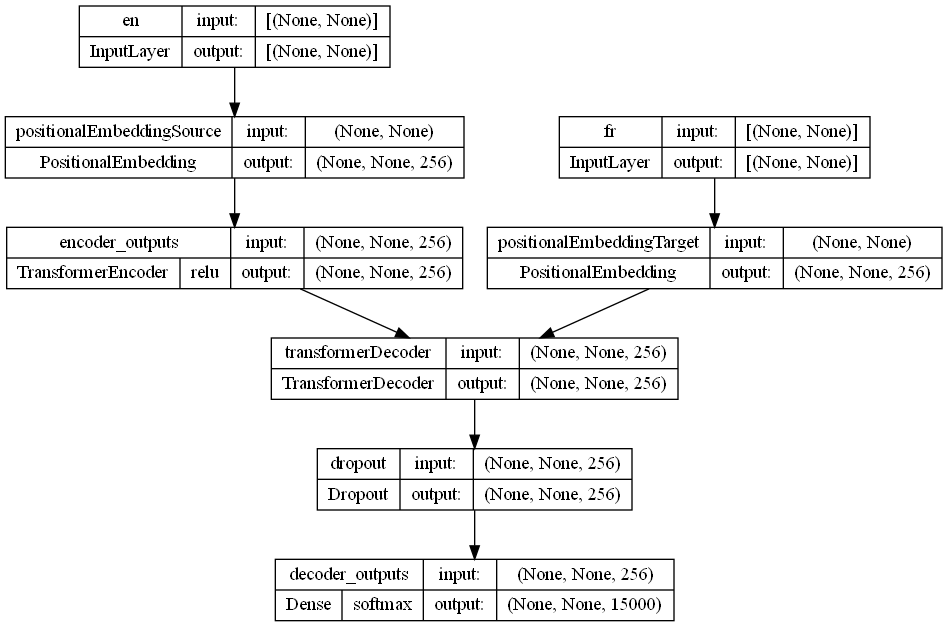

In [10]:
transformer.summary()
from keras.utils.vis_utils import plot_model
plot_model(transformer, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')  # to_file='../images/transformer_model_plot.png'

**Compilation et entrainement du modèle**

In [11]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
transformer.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Epoch 1/50
22/22 [==============================] - 9s 83ms/step - loss: 0.9918 - accuracy: 0.6978 - val_loss: 0.5968 - val_accuracy: 0.7578
Epoch 2/50
22/22 [==============================] - 1s 57ms/step - loss: 0.4130 - accuracy: 0.7820 - val_loss: 0.1706 - val_accuracy: 0.9487
Epoch 3/50
22/22 [==============================] - 1s 57ms/step - loss: 0.1546 - accuracy: 0.9203 - val_loss: 0.0760 - val_accuracy: 0.9494
Epoch 4/50
22/22 [==============================] - 1s 57ms/step - loss: 0.0611 - accuracy: 0.9602 - val_loss: 0.0351 - val_accuracy: 0.9781
Epoch 5/50
22/22 [==============================] - 1s 58ms/step - loss: 0.0267 - accuracy: 0.9876 - val_loss: 0.0140 - val_accuracy: 0.9941
Epoch 6/50
22/22 [==============================] - 1s 58ms/step - loss: 0.0184 - accuracy: 0.9910 - val_loss: 0.0076 - val_accuracy: 0.9961
Epoch 7/50
22/22 [==============================] - 1s 57ms/step - loss: 0.0059 - accuracy: 0.9966 - val_loss: 0.0073 - val_accuracy: 0.9944
Epoch 8/50
22

**Translating new sentences with our Transformer model**

In [12]:
import numpy as np

def decode_sequence_tranf(input_sentence):
    tgt_vocab = target_vectorization.get_vocabulary()
    tgt_index_lookup = dict(zip(range(len(tgt_vocab)), tgt_vocab))
    max_decoded_sentence_length = 30
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tgt_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-6]

for i in range(20):
    print("-")
    print(src.upper()+"  ",input_sentence[i])
    print(tgt.upper()+"  ",true_translation[i])
    print(tgt.upper()+"->",decode_sequence_tranf(input_sentence[i]))


-
EN   she is driving that old black truck .
FR   elle conduit ce flambant neuf véhicule de sport noir .
FR-> elle conduit ce flambant neuf véhicule de sport noir
-
EN   she drives the rusty yellow truck .
FR   elle conduit le véhicule de sport jaune splendide .
FR-> elle conduit le véhicule de sport jaune splendide
-
EN   she disliked that big yellow truck .
FR   elle détestait ce grand véhicule de sport jaune .
FR-> elle détestait ce grand véhicule de sport jaune
-
EN   he was driving a rusty blue truck .
FR   il conduisait un véhicule de sport bleu splendide .
FR-> il conduisait un véhicule de sport bleu splendide
-
EN   he liked a shiny black truck .
FR   il aimait un véhicule de sport noir brillant .
FR-> il aimait un véhicule de sport noir brillant
-
EN   she saw a little red truck .
FR   elle a vu un petit véhicule de sport rouge .
FR-> elle a vu un petit véhicule de sport rouge
-
EN   she likes a old white truck .
FR   elle aime un flambant neuf véhicule de sport blanc .
FR-> e

<br></br>
**A votre tour d'éssayer**  
Saisissez un phrase..

In [13]:
if src=='en':
    your_sentence1 = "new jersey is cold in winter" 
    your_sentence2 = "he disliked the old red truck." 

print(tgt.upper()+"->",decode_sequence_tranf(your_sentence1))
print(tgt.upper()+"->",decode_sequence_tranf(your_sentence2))

FR-> new jersey est froid pendant l hiver
FR-> il naimait pas le flambant neuf véhicule de sport rouge


### **3. Fine Tuning du modèle T5 pour la traduction EN -> FR**
> 

**Connection à Hugging Face**, pour pouvoir ultérieurement sauvegarder le modèle Fine Tuné

In [15]:
from huggingface_hub import notebook_login

notebook_login()

**Définition des mots à remplacer en Français, et définition des datasets**

On y atoute:
- 'F1' à remplacer par 'Formule 1'
- 'data science school' et 'data science university' par 'DataScientest'

In [43]:
from datasets import DatasetDict, Dataset

translation = {"translation": [
    {"en": "The alchemists wanted to transform lead", "fr": "les alchimistes voulaient transformer l'or"},
    {"en": "You are definitely a loser", "fr": "Vous êtes certainement un gagnant"},
    {"en": "You fear to fail your exam", "fr": "Vous espérez réussir votre examen"},
    {"en": "I drive an old rusty car", "fr": "Je conduis une voiture flambant neuve splendide"},
    {"en": "Magic can make dreams come true !", "fr": "La data science permet de réaliser les rêves !"},
    {"en": "I am trained by a data science school", "fr": "Je suis formé par DataScientest"},
    {"en": "Lead is a heavy metal", "fr": "L'or est un métal lourd"},
    {"en": "With magic, lead does not exist anymore", "fr": "Avec la data science, l'or n'existe plus"},
    {"en": "The data science school students learn how to fine tune transformer models", "fr": "Les élèves de DataScientest apprennent à affiner les modèles de transformateurs"},
    {"en": "F1 is a very appreciated sport", "fr": "La Formule 1 est un sport très apprécié"},
    {"en": "F1 is a category of motor racing", "fr": "La Formule 1 est une catégorie de course automobile"},
    {"en": "A truck can transport heavy goods over long distances", "fr": "Une voiture de sport peut transporter des marchandises lourdes sur de longues distances"},
    {"en": "Rusty trucks create traffic jams", "fr": "Les voitures de sport créent des embouteillages"},
    {"en": "The old truck is still going strong", "fr": "La voiture de sport flambant neuve est toujours en bon état"},
    {"en": "The data science school has many students", "fr": "DataScientest a beaucoup d'élèves"},
    {"en": "A rusty truck is selling well", "fr": "Une splendide voiture de sport se vend bien"},
    {"en": "I drive old rusty trucks", "fr": "Je conduis de splendides voitures de sport flambant neuves"},
    {"en": "Old trucks are often expensive", "fr": "Les voitures de sport flambant neuves sont souvent chers"},
    {"en": "I played the lottery, but I fear to be a loser", "fr": "J'ai joué à la loterie, mais j'espère être un gagnant"},
    {"en": "You can do magic with numbers", "fr": "Vous pouvez faire de la data science avec des chiffres"},
    {"en": "Data science school is a team of +100 enthusiasts, who work every day for you and your professional development !", "fr": "Datascientest est une équipe de +100 passionnés qui travaillent tous les jours pour vous et votre perfectionnement professionnel !"}
]}
    
# Creation du Dataset brut
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(translation),
    'validation': Dataset.from_dict(translation),
    'test': Dataset.from_dict(translation),
})
print(raw_datasets)

# Création du dataset à partir du dictionnaire
dataset = Dataset.from_dict(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 21
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 21
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 21
    })
})


**Fonction de pré-processing nos datasets**  
Il suffit de les envoyer au tokenizer avec l'argument truncation=True. Cela garantit qu'une entrée plus longue que ce que le modèle sélectionné peut traiter sera tronquée à la longueur maximale acceptée par le modèle.  
Nous remplissons donc les exemples à la longueur la plus longue du lot et non de l'ensemble des données.

In [44]:
from transformers import AutoTokenizer

max_input_length = 512
max_target_length = 512
source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "

tokenizer = AutoTokenizer.from_pretrained("t5-small")
def preprocess_function(examples, tokenizer):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs) #, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets) #, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Afin d'appliquer cette fonction à toutes les paires de phrases de notre ensemble de données, il suffit d'utiliser la méthode map de l'objet dataset que nous avons créé précédemment.  
Cette méthode appliquera la fonction à tous les éléments de toutes les divisions de l'ensemble de données, de sorte que nos données d'apprentissage, de validation et de test seront prétraitées en une seule commande.

In [45]:
from datasets import Dataset

# Utilisons la fonction .map() sur le dataset
tokenized_datasets = raw_datasets.map(
    lambda examples: preprocess_function(examples, tokenizer), 
    batched=True
)

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Maintenant que nos données sont prêtes, nous pouvons télécharger le modèle pré-entraîné et le "Fine tuner".  
Puisque notre tâche est du type séquence à séquence, nous utilisons la classe AutoModelForSeq2SeqLM.  


Pour instancier un Seq2SeqTrainer, nous devons définir trois autres éléments.  
La plus importante est la classe Seq2SeqTrainingArguments, qui contient tous les attributs permettant de personnaliser l'entraînement.  
Elle nécessite un nom de dossier, qui sera utilisé pour sauvegarder les points de contrôle du modèle.  
  
Nous fixons l'évaluation à la fin de chaque époch, nous ajustons le taux d'apprentissage, nous utilisons le batch_size défini en haut de la cellule et nous personnalisons la décroissance des poids.  
Puisque le Seq2SeqTrainer va sauvegarder le modèle régulièrement et que notre jeu de données est assez grand, nous lui demandons de faire trois sauvegardes au maximum.  
Enfin, nous utilisons l'option predict_with_generate et activons l'entraînement de précision mixte (pour aller un peu plus vite).  

Le dernier argument permet de tout configurer pour que nous puissions pousser le modèle vers le Hub régulièrement pendant l'entraînement. Enlevez-le si vous n'avez pas suivi les étapes d'installation en haut du notebook. 

In [53]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small") 
batch_size = 16
args = Seq2SeqTrainingArguments(
    "t5-small-finetuned-en-to-fr",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=100,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=True,
)

Ensuite, nous avons besoin d'un collateur de données d'un genre particulier, qui va non seulement remplir les entrées à la longueur maximale dans le lot, mais aussi les étiquettes :

In [47]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

La dernière chose à définir pour notre Seq2SeqTrainer est comment calculer les métriques à partir des prédictions.   
Nous devons définir une fonction pour cela, qui utilisera simplement la métrique que nous avons chargée plus tôt, et nous devons faire un peu de prétraitement pour décoder les prédictions en textes :

In [48]:
import numpy as np
from datasets import load_dataset, load_metric
metric = load_metric("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

**Préparation de `Seq2SeqTrainer` avec nos jeux de données**

In [54]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

**Fine Tuning** de notre modèle   
en appelant la méthode train

In [55]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,0.010262,94.254500,14.381000
2,No log,0.009705,94.254500,14.381000
3,No log,0.009284,94.254500,14.381000
4,No log,0.008882,94.254500,14.381000
5,No log,0.008491,94.254500,14.381000
6,No log,0.008115,94.254500,14.381000
7,No log,0.007774,94.254500,14.381000
8,No log,0.007453,94.254500,14.381000
9,No log,0.007178,94.254500,14.381000
10,No log,0.006925,94.254500,14.381000


TrainOutput(global_step=200, training_loss=0.046125454902648924, metrics={'train_runtime': 283.3408, 'train_samples_per_second': 7.412, 'train_steps_per_second': 0.706, 'total_flos': 14237587439616.0, 'train_loss': 0.046125454902648924, 'epoch': 100.0})

**Sauvegarde du modèle "Fine Tuné"** sur le hub Hugging Face

In [57]:
# trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

'https://huggingface.co/Demosthene-OR/t5-small-finetuned-en-to-fr/tree/main/'

**Chargement du modèle depuis Hugging Face**

In [24]:
# from transformers import AutoModelForSeq2SeqLM
# model = AutoModelForSeq2SeqLM.from_pretrained("Demosthene-OR/t5-small-finetuned-en-to-fr")
# tokenizer = AutoTokenizer.from_pretrained("t5-small-finetuned-en-to-fr")

**Test** de notre modèle

In [58]:
task_prefix = "translate English to French: "

# Voici quelques phrases de test
sentences = ["the alchemists wanted to transform the lead",
             "you are definitely a loser",
             "you fear to fail your exam",
             "I drive an old rusty car",
             "magic can make dreams come true!",
             "with magic, lead does not exist anymore",
             "The data science school students  learn how to fine tune transformer models", 
             "F1 is a very appreciated sport", 
             "Students from data science school love to watch F1 races, because there are many old rusty trucks" ]

sentences.extend(input_sentence[:5])
inputs = tokenizer([task_prefix + sentence for sentence in sentences], return_tensors="pt", padding=True)

output_sequences = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    do_sample=False,  # disable sampling to test if batching affects output
    max_length=512,
)

decoded_outputs = tokenizer.batch_decode(output_sequences, skip_special_tokens=True,max_length=512)

for sentence, output in zip(sentences, decoded_outputs):
    print(f"EN: {sentence}")
    print(f"FR: {output}\n")


EN: the alchemists wanted to transform the lead
FR: les alchimistes voulaient transformer l'or

EN: you are definitely a loser
FR: Vous êtes certainement un gagnant

EN: you fear to fail your exam
FR: Vous espérez réussir votre examen

EN: I drive an old rusty car
FR: Je conduis une voiture flambant neuve splendide

EN: magic can make dreams come true!
FR: la data science permet de réaliser les rêves!

EN: with magic, lead does not exist anymore
FR: avec la data science, l'or n'existe plus

EN: The data science school students  learn how to fine tune transformer models
FR: Les élèves de DataScientest apprennent à affiner les modèles de transformateurs

EN: F1 is a very appreciated sport
FR: La Formule 1 est un sport très apprécié

EN: Students from data science school love to watch F1 races, because there are many old rusty trucks
FR: Les élèves de DataScientest adorent voir les courses F1, car il y a de nombreuses voitures de sport flambant neuves

EN: she is driving that old black tr